# **Wave**
Correlations between a **combined wave index** *(swh x mwp)* and the mean amplitude for different frequencies

Initialisation

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import xarray as xr

from scipy.signal import medfilt
from utils.data_reading.sound_data.station import StationsCatalog

In [11]:
sys.path.append("/home/imonge/PycharmProjects/PythonProject/toolbox/src") # Path of the root directory
catalog_path = "/media/imonge/CORSAIR" # Path of the hard disk containing the MAHY data

stations = StationsCatalog(catalog_path)
# %matplotlib qt #-> Use this in case you want to have the plot in a new window

In [12]:
# Take the time dates from the MAHY csv
cat_info = pd.read_csv(catalog_path + '/MAHY/MAHY.csv', parse_dates=['date_start', 'date_end'])
cat_info.set_index('station_name', inplace=True)
cat_info["date_start"] = pd.to_datetime(cat_info["date_start"])
cat_info["date_end"] = pd.to_datetime(cat_info["date_end"])

# Determine the first date and last date of all MAHY campaigns to match with the current speed dates
date_start_total = cat_info["date_start"].min()
date_end_total = cat_info["date_end"].max()

Save wave data in a numpy file

In [4]:
output_path_wave = "/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_soundscape/wave"

for station in stations:

    hydro_number = station.name[-1]
    station_code = f"h{hydro_number}"

    date_start = station.date_start
    date_end = station.date_end

    wave_path = f"/home/imonge/PycharmProjects/PythonProject/toolbox/src/ERA5_concat/ERA5_MAHY*{hydro_number}_waves_merged.nc"
    wave_data = xr.open_dataset(wave_path)

    t = pd.to_datetime(wave_data["valid_time"].values)

    mask = (t>date_start) & (t<date_end)

    swh = np.array(wave_data["swh"]).flatten()
    mwp = np.array(wave_data["mwp"]).flatten()
    combined_wave_index = (swh*mwp)[mask]

    np.save(os.path.join(output_path_wave, f"combined_wave_index_" + station_code + ".npy"), combined_wave_index)

Choose the stations

In [13]:
# Select the stations you want to plot. /!\ You can only choose stations for one hydrophone
selected_stations = ["MAHY02",
                     "MAHY12",
                     "MAHY22",
                     "MAHY32",
                     "MAHY42"
                     ]

hydrophone_number = [station[-1] for station in selected_stations]
# Check that only one hydrophone is chosen
if len(set(hydrophone_number))>1:
    raise ValueError("You have selected more than one hydrophone")
else:
    print(f"Hydrophone n°{hydrophone_number[0]} selected")

Hydrophone n°2 selected


Spectrogram with wave index overlaid for the stations selected

/tmp/ipykernel_28268/170444608.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0.5, 1.0, 'Combined wave index (m/s) overlaid on the spectrogram')

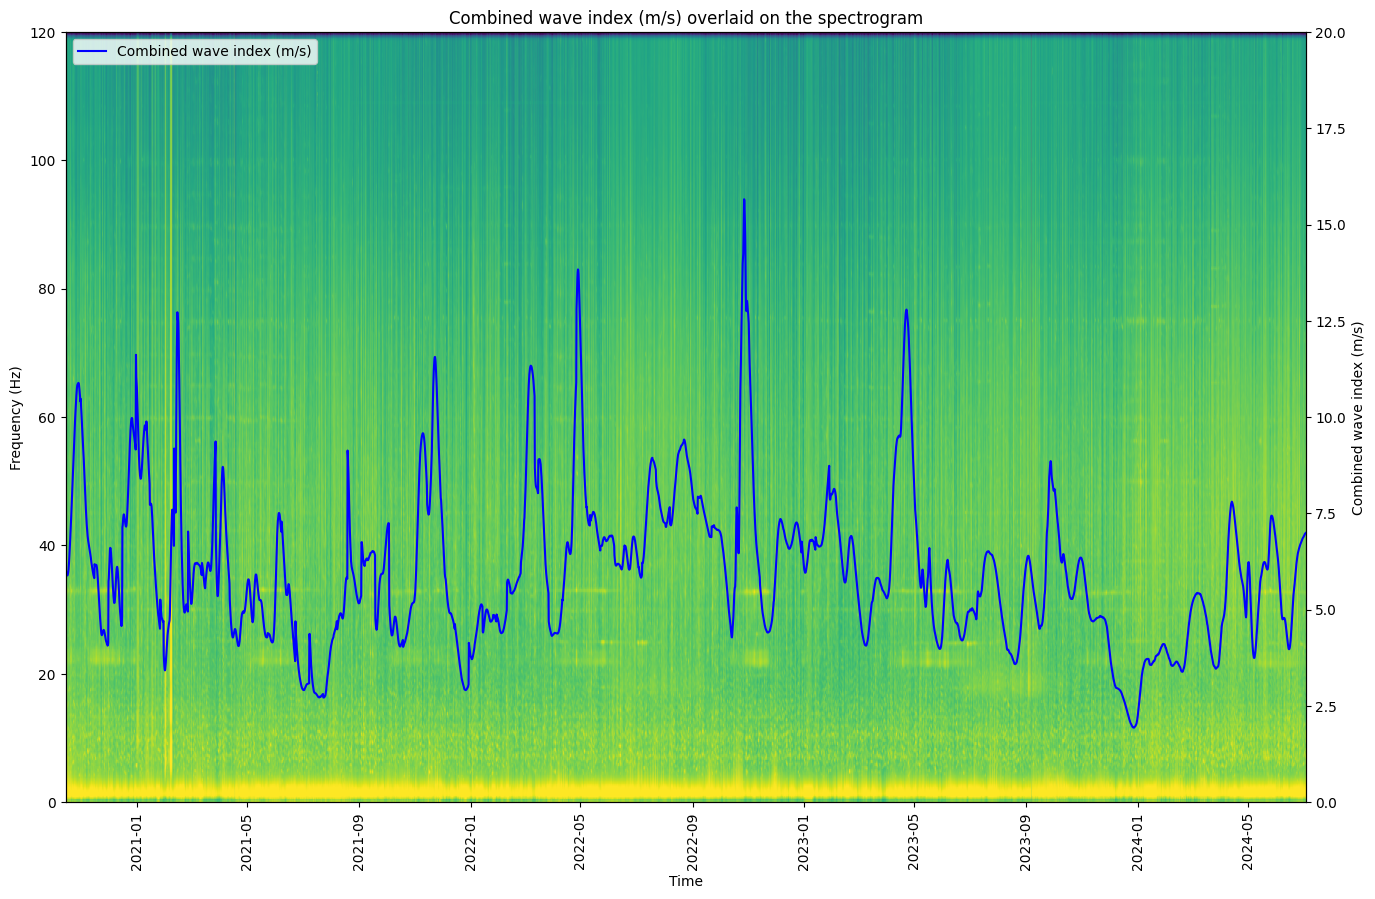

In [14]:
# Path of the directories containing psds and combined wave index data
mahy_path = "/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_mahy"
wave_path = f"/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_soundscape/wave/combined_wave_index_h{hydrophone_number[0]}.npy"

# Take the dates from de MAHY csv
date_start = cat_info["date_start"].loc[selected_stations[0]]
date_end = cat_info["date_end"].loc[selected_stations[-1]]

# Spectrogram
psds_all = []

for station in selected_stations:
    psd_path = os.path.join(mahy_path, f"PSDS_{station}.npy")
    psds = np.load(psd_path)
    psds_all.append(psds)

# Concatenate psds
final_psd = np.vstack(psds_all)

# Combined wave index
combined_wave_index = np.load(wave_path)

dates_all = pd.date_range(start=date_start, end=date_end, periods=len(combined_wave_index))
assert len(combined_wave_index) == len(dates_all); "Mismatch in combined_wave_index and dates_all length"

# Interpolate wave index in order to correspond to the spectrogram dates
if len(dates_all) != len(combined_wave_index):
    combined_wave_index_interp = np.interp(pd.to_numeric(dates_all), pd.to_numeric(dates_all), combined_wave_index)

else:
    combined_wave_index_interp = combined_wave_index

# Create plot and axis
fig, ax = plt.subplots(figsize = (16,10))
ax1 = ax.twinx() # Second axis for wave index

sp = ax.imshow(10*np.log10(final_psd.T + 1e-12), aspect="auto", origin="lower", cmap="viridis", extent=(date_start, date_end, 0, 120), vmin=10, vmax=95)

# Trace wave index on the second axis
ax1.plot(dates_all, combined_wave_index_interp,label="Combined wave index (m/s)", color="blue")
ax1.set_ylim(0,20) #limites ax1
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(False, axis='y') # No grid for the frequency

# Add labels
ax.set_xlabel("Time")
ax.set_ylabel("Frequency (Hz)")
ax1.set_ylabel("Combined wave index (m/s)")
ax1.legend(loc="upper left")
ax.set_title("Combined wave index (m/s) overlaid on the spectrogram")

Correlations between the median amplitude and the combined wave index as a function of frequency

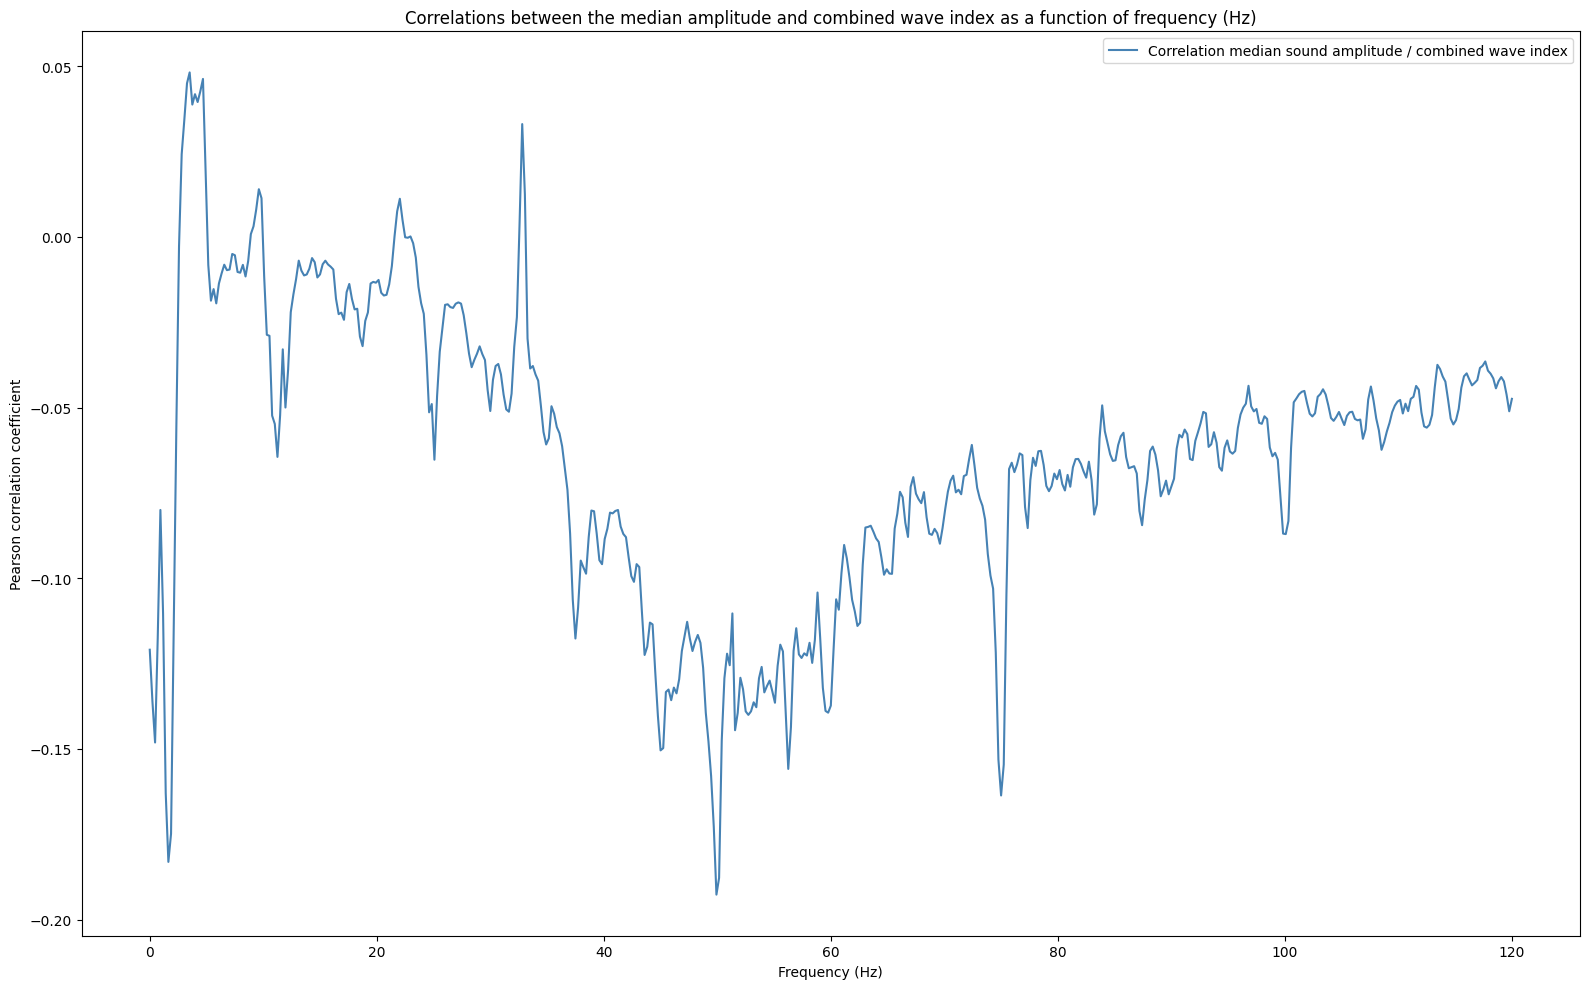

In [15]:
# Define the amplitude correlations
amplitude_corr = []

# Calculate the correlation between the filtered amplitude and the interpolated wind
for i in range(final_psd.shape[1]):
    amplitude = final_psd[:, i]
    amplitude_filt = medfilt(amplitude, kernel_size=51)

    amplitude_steps = amplitude_filt.shape[0]
    t_amplitude = pd.date_range(
        start=date_start,
        end=date_end,
        periods=amplitude_steps)

    #interpolated_wave interp1d(pd.to_numeric(dates_all), combined_wave_index, bounds_error=False)(pd.to_numeric(t_amplitude))
    interpolated_wave = np.interp(pd.to_numeric(t_amplitude), pd.to_numeric(dates_all), combined_wave_index)
    validmask = (~np.isnan(interpolated_wave)) & (~np.isnan(amplitude_filt) & (amplitude_filt != 0)) # remove nan values and null values

    if np.sum(validmask) > 0:
        corr_matrix = np.corrcoef(interpolated_wave[validmask], amplitude_filt[validmask])
        amplitude_corr.append(corr_matrix[0, 1])
    else:
        amplitude_corr.append(np.nan)

# Calculate the associated frequencies
fs = 240
nperseg = 1024
frequencies = np.fft.rfftfreq(nperseg, d=1 / fs)

# Create plot
plt.figure(figsize=(16,10))
plt.plot(frequencies, amplitude_corr, color="steelblue", label="Correlation median sound amplitude / combined wave index")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Pearson correlation coefficient")
plt.title("Correlations between the median amplitude and combined wave index as a function of frequency (Hz)")
plt.legend()
plt.tight_layout()
plt.show()